## SGNS - Skip Gram Negative Sampling

In [1]:
import os
import math
import random
import numpy as np
from collections import Counter 

CORPUS_PATH = "ed3book_aug25 no changes.pdf"
MIN_COUNT = 3
WINDOW_SIZE = 5
EMBED_DIM = 200
NEG_K = 5
BATCH_SIZE = 512
EPOCHS = 1000
LR = 0.025
SUBSAMPLE_T = 1e-5
SAVE_TXT = "w2v_vectors.txt"
SAVE_NPY = "w2v_vectors.npy"


np.random.seed(42)
random.seed(42)

In [2]:
!pip install PyPDF2

In [3]:
#creating the text corpus from the textbook ed3
from PyPDF2 import PdfReader
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path,'rb') as f:
        reader = PdfReader(f)
        for page_num, page in enumerate(reader.pages):
            text += page.extract_text() or ""
    return text 

pdf_path = "C:\\Users\\moham\\Desktop\\deeplearning\\ed3book_aug25 no changes.pdf"
corpus_text = extract_text_from_pdf(pdf_path)

print("sample text: \n", corpus_text[:500])

ModuleNotFoundError: No module named 'PyPDF2'

!

In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000   # raise the limit safely (2 million chars)

def clean_and_tokenize_spacy(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return tokens


ModuleNotFoundError: No module named 'spacy'

In [28]:
def save_tokens_to_txt(tokens, out_path="corpus_100k.txt"):
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(" ".join(tokens))
    print(f"Saved cleaned corpus to {out_path}")


In [133]:
tokens = clean_and_tokenize_spacy(corpus_text[:1000000])
save_tokens_to_txt(tokens)
print("total tokens: ", len(tokens))

Saved cleaned corpus to corpus_100k.txt
total tokens:  75851


In [65]:
freq = Counter(tokens)
vocab = [w for w,c in freq.items() if c>=MIN_COUNT]
word2idx = {w: i for i,w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
V = len(vocab)
print("Vocabulary Size: ", V)

Vocabulary Size:  76


In [66]:
print(tokens)

['speech', 'language', 'processing', 'introduction', 'natural', 'language', 'processing', 'computational', 'linguistic', 'speech', 'recognition', 'language', 'model', 'edition', 'draft', 'daniel', 'jurafsky', 'stanford', 'university', 'james', 'martin', 'university', 'colorado', 'boulder', 'copyright', 'right', 'reserve', 'draft', 'august', 'comment', 'typo', 'content', 'large', 'language', 'model', 'introduction', 'word', 'token', 'gram', 'language', 'model', 'logistic', 'regression', 'embedding', 'neural', 'network', 'large', 'language', 'model', 'transformer', 'mask', 'language', 'model', 'post', 'training', 'instruction', 'tuning', 'alignment', 'test', 'time', 'pute', 'retrieval', 'base', 'model', 'machine', 'translation', 'rnn', 'lstms', 'phonetic', 'speech', 'feature', 'extraction', 'automatic', 'speech', 'recognition', 'text', 'speech', 'annotate', 'linguistic', 'structure', 'sequence', 'labeling', 'part', 'speech', 'name', 'entity', 'context', 'free', 'grammar', 'constituency',

In [67]:
pairs = []
for i,w in enumerate(tokens):
    if w not in word2idx:
        continue
    center = word2idx[w]
    for j in range(max(0,1 - WINDOW_SIZE), min(len(tokens), i+WINDOW_SIZE+1)):
        if j==i:
            continue
        if tokens[j] in word2idx:
            pairs.append((center, word2idx[tokens[j]]))

print("Total pairs: ", len(pairs))

Total pairs:  101248


In [68]:
#initialize random weight matrix for the vocan with dimension VocabSize
W_in = np.random.uniform(-0.5/EMBED_DIM, 0.5/EMBED_DIM, (V, EMBED_DIM))
W_out = np.zeros((V, EMBED_DIM))

In [69]:
freq_arr = np.array([freq[w] for w in vocab], dtype=np.float64)
prob = freq_arr ** 0.75
prob /= prob.sum()
cdf = np.cumsum(prob)

In [70]:
def sample_negatives(k):
    r = np.random.rand(k)
    return np.searchsorted(cdf, r)
def sigmoid(x):
    return 1 / (1+ np.exp(-np.clip(x, -6, 6)))

In [76]:
for epoch in range(EPOCHS):
    total_loss = 0
    random.shuffle(pairs)
    for center, context in pairs:
        negs = sample_negatives(NEG_K)
        v = W_in[center]
        u_pos = W_out[context]
        u_negs = W_out[negs]

        score_pos = sigmoid(np.dot(v,u_pos))
        grad_pos  = (score_pos -1)
        W_in[center] -= LR * grad_pos * u_pos 
        W_out[context] -= LR * grad_pos * v 

        score_negs = sigmoid(np.dot(u_negs, v))
        grad_negs = score_negs 
        W_out[negs] -= LR * grad_negs[:, None] * v[None, :]
        W_in[center] -= LR* np.sum(grad_negs[:, None] * u_negs, axis=0)

        total_loss += -np.log(score_pos + 1e-10) - np.sum(np.log(1-score_negs + 1e-10))

    print(f"Epoch {epoch+1}/{EPOCHS} | AVG Loss : {total_loss/ len(pairs):.4f}")

Epoch 1/1000 | AVG Loss : 8.9897
Epoch 2/1000 | AVG Loss : 8.9818
Epoch 3/1000 | AVG Loss : 9.0256
Epoch 4/1000 | AVG Loss : 8.9979
Epoch 5/1000 | AVG Loss : 9.0003
Epoch 6/1000 | AVG Loss : 8.9986
Epoch 7/1000 | AVG Loss : 8.9993
Epoch 8/1000 | AVG Loss : 9.0064
Epoch 9/1000 | AVG Loss : 9.0061
Epoch 10/1000 | AVG Loss : 8.9934
Epoch 11/1000 | AVG Loss : 8.9779
Epoch 12/1000 | AVG Loss : 9.0028
Epoch 13/1000 | AVG Loss : 8.9979
Epoch 14/1000 | AVG Loss : 9.0081
Epoch 15/1000 | AVG Loss : 8.9876
Epoch 16/1000 | AVG Loss : 9.0307
Epoch 17/1000 | AVG Loss : 9.0149
Epoch 18/1000 | AVG Loss : 9.0105
Epoch 19/1000 | AVG Loss : 9.0166
Epoch 20/1000 | AVG Loss : 9.0100
Epoch 21/1000 | AVG Loss : 9.0388
Epoch 22/1000 | AVG Loss : 8.9798
Epoch 23/1000 | AVG Loss : 9.0109
Epoch 24/1000 | AVG Loss : 8.9984
Epoch 25/1000 | AVG Loss : 8.9868
Epoch 26/1000 | AVG Loss : 9.0275
Epoch 27/1000 | AVG Loss : 9.0461
Epoch 28/1000 | AVG Loss : 9.0200
Epoch 29/1000 | AVG Loss : 9.0141
Epoch 30/1000 | AVG Los

KeyboardInterrupt: 

In [104]:
grad_negs[:, None] * v[None, :]

array([[ 3.26513599e-05,  3.53815595e-04,  4.65592139e-05,
        -4.41670571e-05, -8.29908375e-05, -5.11228144e-05,
         1.26581543e-04,  2.13735946e-04, -1.77565207e-04,
        -1.11586132e-04, -1.86364283e-04,  6.50721733e-05,
        -2.62348047e-05, -7.37498558e-05,  6.82582975e-05,
        -1.17603442e-04,  4.32307887e-04,  2.84607475e-04,
         3.11590580e-04,  2.77685019e-04,  4.04500766e-05,
        -3.18877423e-05, -5.42195363e-04,  4.66235373e-05,
        -5.25235079e-05, -1.30761316e-04,  6.32078890e-05,
         5.88327247e-05, -1.58672334e-04,  2.51301738e-06,
        -2.32036215e-04,  1.07301324e-04,  1.48424409e-05,
        -2.08414621e-04, -3.26509753e-05, -4.16789673e-04,
        -6.51806496e-05, -1.08925832e-04, -3.66990599e-04,
        -2.88425095e-05, -4.49994887e-04,  1.42921441e-04,
         3.80867608e-05, -3.08651816e-05, -1.85564164e-04,
        -9.80972387e-05,  2.56817085e-05,  2.30084449e-04,
         4.57349213e-05,  2.07362457e-04,  3.50993108e-0

In [105]:
(grad_negs[:, None] * v[None, :]).shape

(5, 200)

In [99]:
v[None, :].shape

(1, 200)

In [ ]:
v[None, :]

array([[ 0.01320515,  0.14309321,  0.01882989, -0.01786243, -0.03356388,
        -0.02067554,  0.05119322,  0.08644097, -0.07181248, -0.04512864,
        -0.07537108,  0.02631706, -0.01061011, -0.02982657,  0.02760562,
        -0.04756222,  0.17483776,  0.11510346,  0.1260162 ,  0.11230382,
         0.01635918, -0.01289632, -0.21927942,  0.0188559 , -0.02124202,
        -0.05288364,  0.02556309,  0.02379365, -0.06417166,  0.00101634,
        -0.09384213,  0.04339574,  0.00600271, -0.08428887, -0.01320499,
        -0.16856174, -0.02636093, -0.04405274, -0.14842157, -0.01166474,
        -0.18199089,  0.05780155,  0.01540338, -0.01248277, -0.07504749,
        -0.03967335,  0.01038642,  0.09305278,  0.01849652,  0.08386335,
         0.01419517, -0.04363297,  0.02799262, -0.02805629,  0.02079529,
         0.04041759,  0.00231286,  0.0942269 ,  0.00326737,  0.08729642,
        -0.00027818, -0.02235831, -0.08736841, -0.06284106,  0.0623598 ,
        -0.05903613,  0.06864812, -0.04518115, -0.0

In [103]:
W_out[negs].shape

(5, 200)

In [89]:
grad_negs[:, None]

array([[0.00247262],
       [0.00247262],
       [0.00247262],
       [0.00247262],
       [0.00247262]])

In [78]:
W_in /= np.linalg.norm(W_in, axis=1, keepdims=True) + 1e-12
np.save("word2vec_vectors.npy", W_in)
print("Training complete. Embeddings saved to word2vec_vectors.npy")

Training complete. Embeddings saved to word2vec_vectors.npy


In [79]:
W = np.load("word2vec_vectors.npy")
def nearest(word, topk=10):
    if word not in word2idx:
        print(f"'{word}' not in vocab"); return
    v = W[word2idx[word]]
    sims = W @ v
    sims /= np.linalg.norm(W, axis=1)
    sims /= np.linalg.norm(v)
    for idx in np.argsort(-sims)[:topk]:
        print(idx2word[idx], f"({sims[idx]:.3f})")

nearest("data")
nearest("science")
nearest("model")


'data' not in vocab
'science' not in vocab
model (1.000)
text (0.706)
sequence (0.665)
recognition (0.630)
name (0.608)
gram (0.596)
neural (0.591)
entity (0.590)
machine (0.580)
training (0.549)


In [82]:
!pip install matplotlib

  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl (225 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp311-cp311-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- --

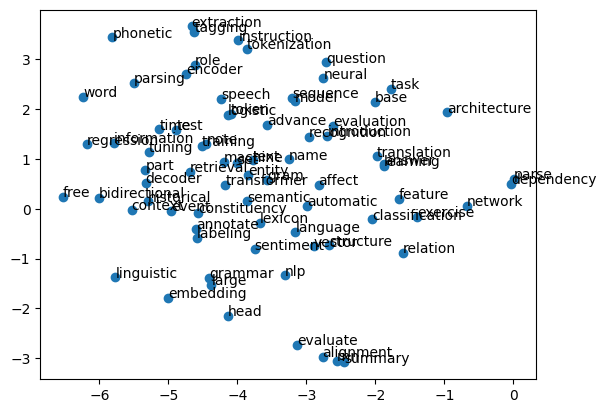

In [106]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

num_points = min(200, len(word2idx))
subset = [word2idx[w] for w in random.sample(list(word2idx.keys()), num_points)]

X = W_in[subset]
X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.scatter(X_2d[:,0], X_2d[:,1])
for i, idx in enumerate(subset):
    plt.annotate(idx2word[idx], (X_2d[i,0], X_2d[i,1]))
plt.show()


In [ ]:
tokens = clean_and_tokenize_spacy(corpus_text)
save_tokens_to_txt(tokens)
print("total tokens: ", len(tokens))

Saved cleaned corpus to corpus_100k.txt
total tokens:  145411


In [1]:
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape 
from tensorflow.keras.optimizers import Adam 
import numpy as np 
import random 
from collections import Counter

CORPUS_FILE = "corpus_100k.txt"
WINDOW_SIZE = 2
EMBED_DIM = 5 
LR = 0.01
MIN_COUNT = 2
EPOCHS = 100


with open(CORPUS_FILE, "r", encoding="utf-8") as f:
    tokens = f.read().split()

freq = Counter(tokens)
vocab = [w for w,c in freq.items() if c>=MIN_COUNT]
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
V = len(vocab)
print("Vocabulary Size: ", V)

Vocabulary Size:  7010


There will be 
N x 2W = Total number of pairs

where N = len(tokens)
      W = Window Size

In [2]:
pairs = [] 
for i, w in enumerate(tokens):
    if w not in word2idx:
        continue 
    center = word2idx[w]
    for j in range(max(0, i-WINDOW_SIZE), min(len(tokens) , i+WINDOW_SIZE + 1)):
        if j == 1:
            continue
        if tokens[j] in word2idx:
            pairs.append((center, word2idx[tokens[j]]))
print("Total Pairs: ",len(pairs))

Total Pairs:  671369


In [3]:
centers , contexts = zip(*pairs)
centers = np.array(centers, dtype="int32")
contexts = np.array(contexts, dtype="int32")

In [4]:
#we will give one input per step , we will send the id of the center word hence input shape (1,)
input_word = Input(shape=(1,))
#we are essesntially creating a Embedding Matrix Win with dim VxD where V = Vocabulary size; D=embedding dimensions D
#Than this embedding when multiplied with input_word , gives the vector of the center word shape 1xEmbedDim
embedding = Embedding(input_dim = V, output_dim = EMBED_DIM, input_length = 1, name="embedding_layer")(input_word) 
#flattens the shape of the vector from 1xEmbDim to (EmbDim,) 
embedding = Reshape((EMBED_DIM,))(embedding)
output = Dense(V, activation='softmax')(embedding)

model = Model(inputs = input_word, outputs= output)
model.compile(loss="sparse_categorical_crossentropy",optimizer=Adam(learning_rate=LR))

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_layer (Embedding)  (None, 1, 5)             35050     
                                                                 
 reshape (Reshape)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 7010)              42060     
                                                                 
Total params: 77,110
Trainable params: 77,110
Non-trainable params: 0
_________________________________________________________________


In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
EPOCHS=1000

with tf.device('/GPU:0'):
    history = model.fit(
        centers,
        contexts,
        epochs=EPOCHS,
        batch_size=100000,
        verbose=1
    )


Epoch 1/1000
7/7 [==============================] - 1s 182ms/step - loss: 6.4405
Epoch 2/1000
7/7 [==============================] - 1s 182ms/step - loss: 6.4405
Epoch 3/1000
7/7 [==============================] - 1s 183ms/step - loss: 6.4404
Epoch 4/1000
7/7 [==============================] - 1s 181ms/step - loss: 6.4404
Epoch 5/1000
7/7 [==============================] - 1s 180ms/step - loss: 6.4403
Epoch 6/1000
7/7 [==============================] - 1s 181ms/step - loss: 6.4403
Epoch 7/1000
7/7 [==============================] - 1s 182ms/step - loss: 6.4402
Epoch 8/1000
7/7 [==============================] - 1s 182ms/step - loss: 6.4402
Epoch 9/1000
7/7 [==============================] - 1s 181ms/step - loss: 6.4402
Epoch 10/1000
7/7 [==============================] - 1s 182ms/step - loss: 6.4401
Epoch 11/1000
7/7 [==============================] - 1s 180ms/step - loss: 6.4401
Epoch 12/1000
7/7 [==============================] - 1s 179ms/step - loss: 6.4401
Epoch 13/1000
7/7 [======

In [20]:
weights = model.get_layer("embedding_layer").get_weights()[0]
np.save("word2vec_keras_embeddings.npy", weights)
print("✅ Training complete! Embeddings saved to 'word2vec_keras_embeddings.npy'")

✅ Training complete! Embeddings saved to 'word2vec_keras_embeddings.npy'


In [21]:
import numpy as np

# Get the learned embedding weights
embedding_matrix = model.get_layer("embedding_layer").get_weights()[0]

print("Embedding matrix shape:", embedding_matrix.shape)  # (vocab_size, embed_dim)


Embedding matrix shape: (7010, 5)


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(word, word2idx, idx2word, embedding_matrix, top_k=10):
    if word not in word2idx:
        print(f"{word} not in vocabulary.")
        return
    word_vec = embedding_matrix[word2idx[word]].reshape(1, -1)
    sims = cosine_similarity(word_vec, embedding_matrix)[0]
    top_indices = np.argsort(sims)[::-1][1:top_k+1]
    return [(idx2word[i], sims[i]) for i in top_indices]


In [23]:
similar = most_similar("language", word2idx, idx2word, embedding_matrix)
for w, s in similar:
    print(f"{w:20s} {s:.3f}")


arge                 0.980
pretraine            0.969
hsu                  0.966
prompting            0.966
leverage             0.965
phisticate           0.965
ost                  0.960
nar                  0.958
nique                0.954
conneau              0.954


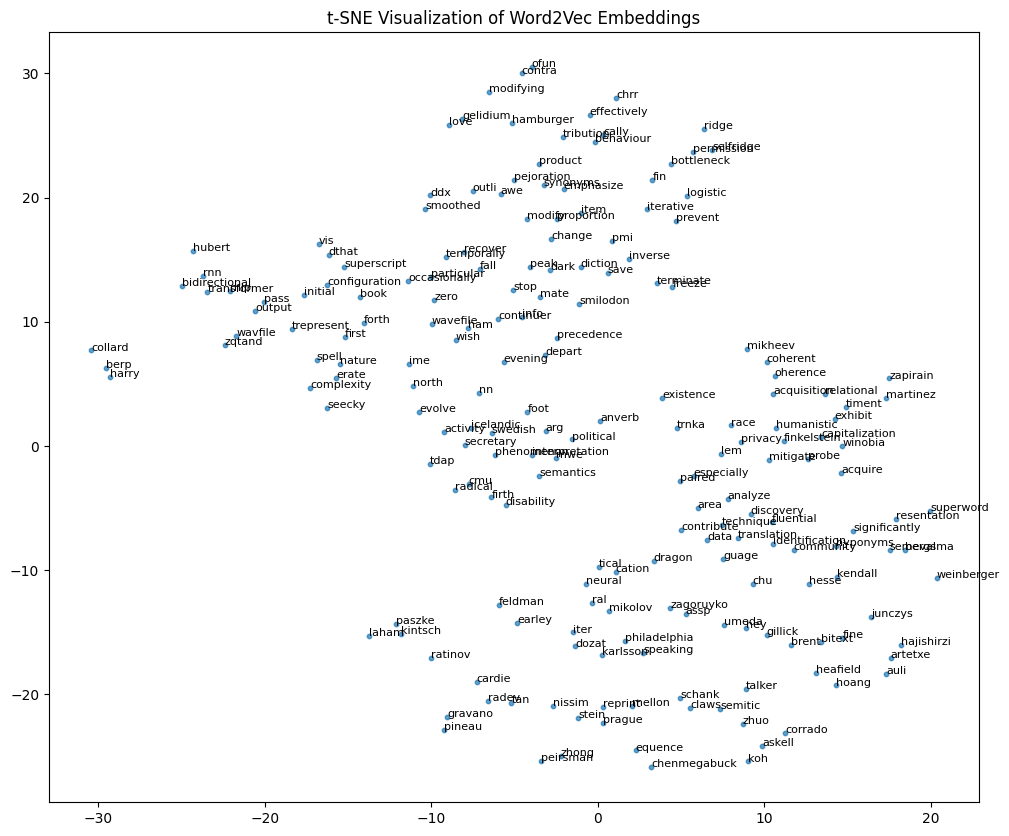

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# pick a random subset for visualization
subset_idx = random.sample(range(len(word2idx)), 200)
subset_vectors = embedding_matrix[subset_idx]
subset_labels  = [idx2word[i] for i in subset_idx]

# Reduce dimensionality
X_2d = TSNE(n_components=2, random_state=42, perplexity=15).fit_transform(subset_vectors)

plt.figure(figsize=(12, 10))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, alpha=0.7)
for i, label in enumerate(subset_labels):
    plt.text(X_2d[i, 0], X_2d[i, 1], label, fontsize=8)
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.show()


In [27]:
import pandas as pd
df = pd.DataFrame(embedding_matrix)
df.insert(0, "word", [idx2word[i] for i in range(len(idx2word))])
df.to_csv("word2vec_embeddings.csv", index=False)
print("✅ Embeddings saved as word2vec_embeddings.csv")


✅ Embeddings saved as word2vec_embeddings.csv


In [18]:
from sklearn.metrics.pairwise import cosine_similarity 

embeddings= np.load("word2vec_keras_embeddings.npy")

def nearest(word, topk=10):
    if word not in word2idx:
        print("word not in vocab")
        return 
    
    idx = word2idx[word]
    v = embeddings[idx].reshape(1,-1)
    sims = cosine_similarity(embeddings, v).flatten()
    top_ids = sims.argsort()[-topk-1:][::-1]
    for i in top_ids:
        print(f"{idx2word[i]} ({sims[i]:.3f})")

nearest("language")

language (1.000)
arge (0.980)
pretraine (0.969)
hsu (0.966)
prompting (0.966)
leverage (0.965)
phisticate (0.965)
ost (0.960)
nar (0.958)
nique (0.954)
conneau (0.954)


In [19]:
nearest('model')

model (1.000)
mlm (0.992)
prompting (0.987)
ﬁnetuning (0.984)
bradley (0.983)
nar (0.982)
pretraine (0.979)
predictor (0.979)
terry (0.978)
cially (0.974)
ﬁnetune (0.973)
